# Processing SUMO Results

Read data and fill in missing edges with 0.

In [2]:
import pandas as pd

data = pd.read_csv("out/routeSampler/small.edgedata.csv", sep=";")[["edge_id", "edge_entered", "edge_speed"]].rename(columns={
    "edge_entered": "flow",
    "edge_speed": "vehicle_speed"})
#data["flow"] = data["flow"].apply(lambda x : x / 24)
data.head()

,edge_id,flow,vehicle_speed
0,1,14274,25.65
1,10,609,26.66
2,100,2928,26.95
3,1000,6285,25.83
4,1001,183,28.72


In [3]:
len(data.index)

1137

In [4]:
covered_edges = data["edge_id"].unique()

for i in range(1220):
    if i not in covered_edges:
        data.loc[len(data.index)] = [i, 0, 0.0]
        
data["edge_id"].nunique()

1220

Read edges and features.

In [5]:
edgelist = pd.read_csv("out/small.edges.csv", sep=";")
edgelist.head()

,edge_from,edge_id,edge_length,edge_numLanes,edge_speed,edge_to
0,1614922744,0,23.141939,2,29.0576,1614922747
1,269459339,1,60.826398,5,29.0576,269459341
2,1621320618,2,109.464966,2,29.0576,1621320622
3,269459229,3,160.720645,3,29.0576,269459230
4,607954833,4,173.017706,3,29.0576,1613371666


In [6]:
edgelist = pd.merge(edgelist, data, on="edge_id")

ordered_cols = ["edge_id", "edge_from", "edge_to", "edge_length", "edge_numLanes", "edge_speed", "flow", "vehicle_speed"]
edgelist = edgelist[ordered_cols]

edgelist.head()

,edge_id,edge_from,edge_to,edge_length,edge_numLanes,edge_speed,flow,vehicle_speed
0,0,1614922744,1614922747,23.141939,2,29.0576,0.0,0.00
1,1,269459339,269459341,60.826398,5,29.0576,14274.0,25.65
2,2,1621320618,1621320622,109.464966,2,29.0576,1149.0,27.70
3,3,269459229,269459230,160.720645,3,29.0576,7974.0,25.03
4,4,607954833,1613371666,173.017706,3,29.0576,6504.0,26.02


Check values for flow and speed.

In [7]:
edgelist["flow"].nunique()

742

In [8]:
(edgelist["flow"] == 0).sum()

106

In [9]:
edgelist["flow"].median()

1996.5

In [10]:
(edgelist["vehicle_speed"] < 1).sum()

83

In [11]:
edgelist.to_csv("out/small.results.csv", index=False)

In [12]:
nodes = pd.read_csv("out/small.nodes.csv", sep=";").set_index("node_id")
nodes.head()

,node_x,node_y
node_id,,
269459457,-118.215300,34.056067
317640716,-118.221778,34.036254
317640717,-118.221770,34.036083
317640718,-118.221753,34.035806
317640719,-118.221718,34.035521


## Visualizations

Flow at each edge:

In [13]:
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt


positions = {v: (k["node_x"], k["node_y"]) for v, k in nodes.to_dict("index").items()}
cmap = mpl.colormaps["viridis"]

G = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"],
                           create_using=nx.DiGraph)
G.number_of_edges()

1220

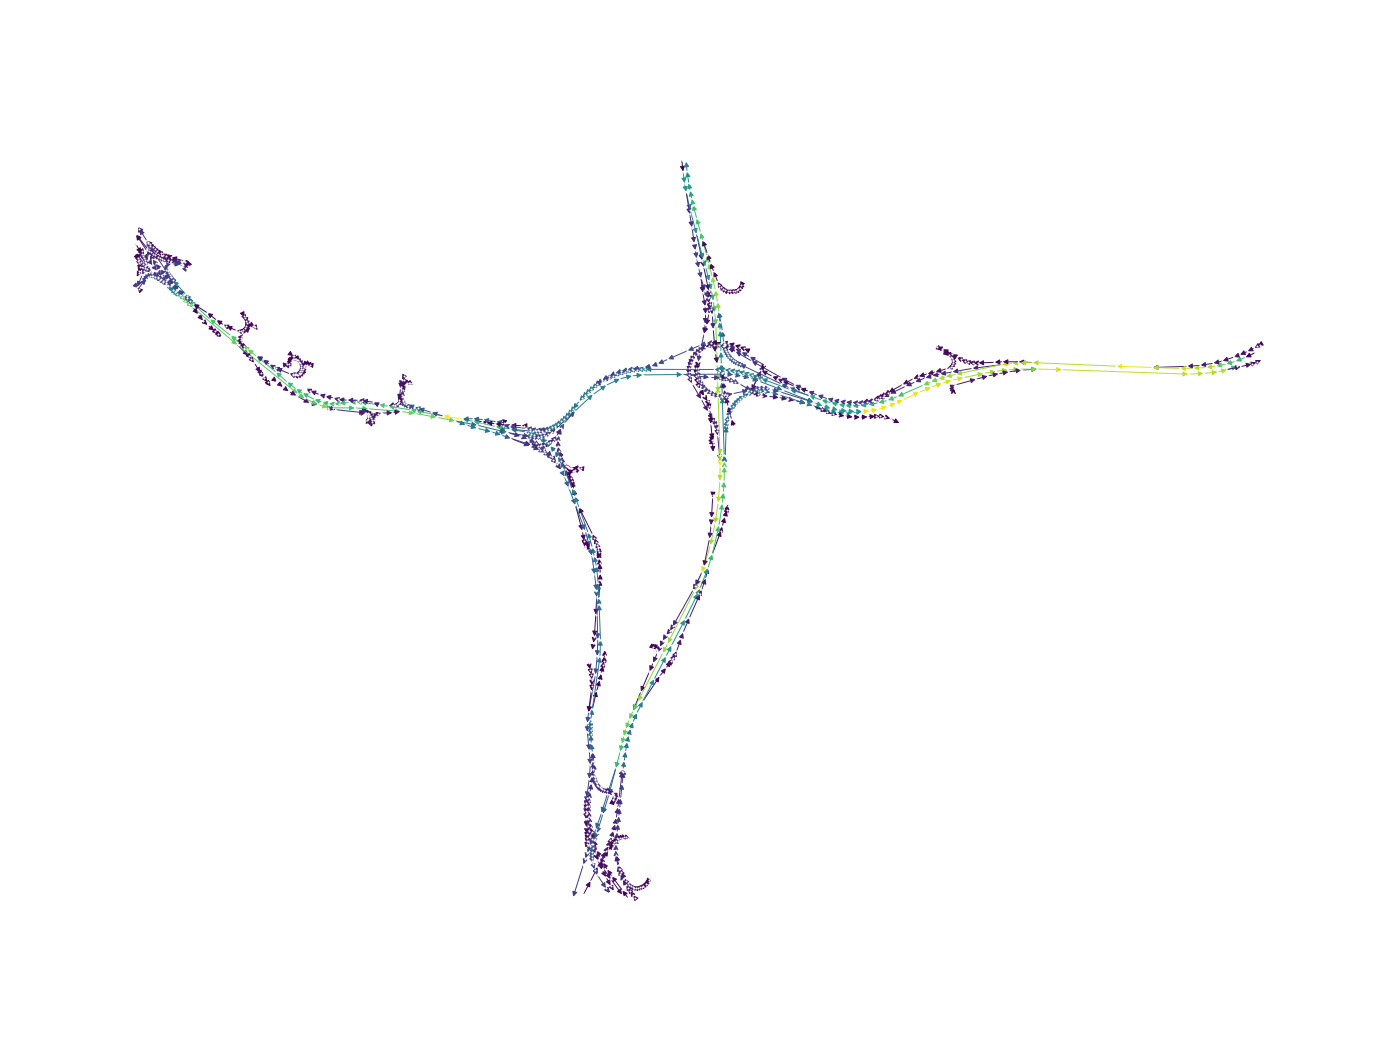

In [14]:
nx.set_node_attributes(G, nodes.to_dict("index"))

plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
edge_colors = [(G[u][v]["flow"]) for u, v in G.edges]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)
plt.show()

Edges with 0 flow (in red):

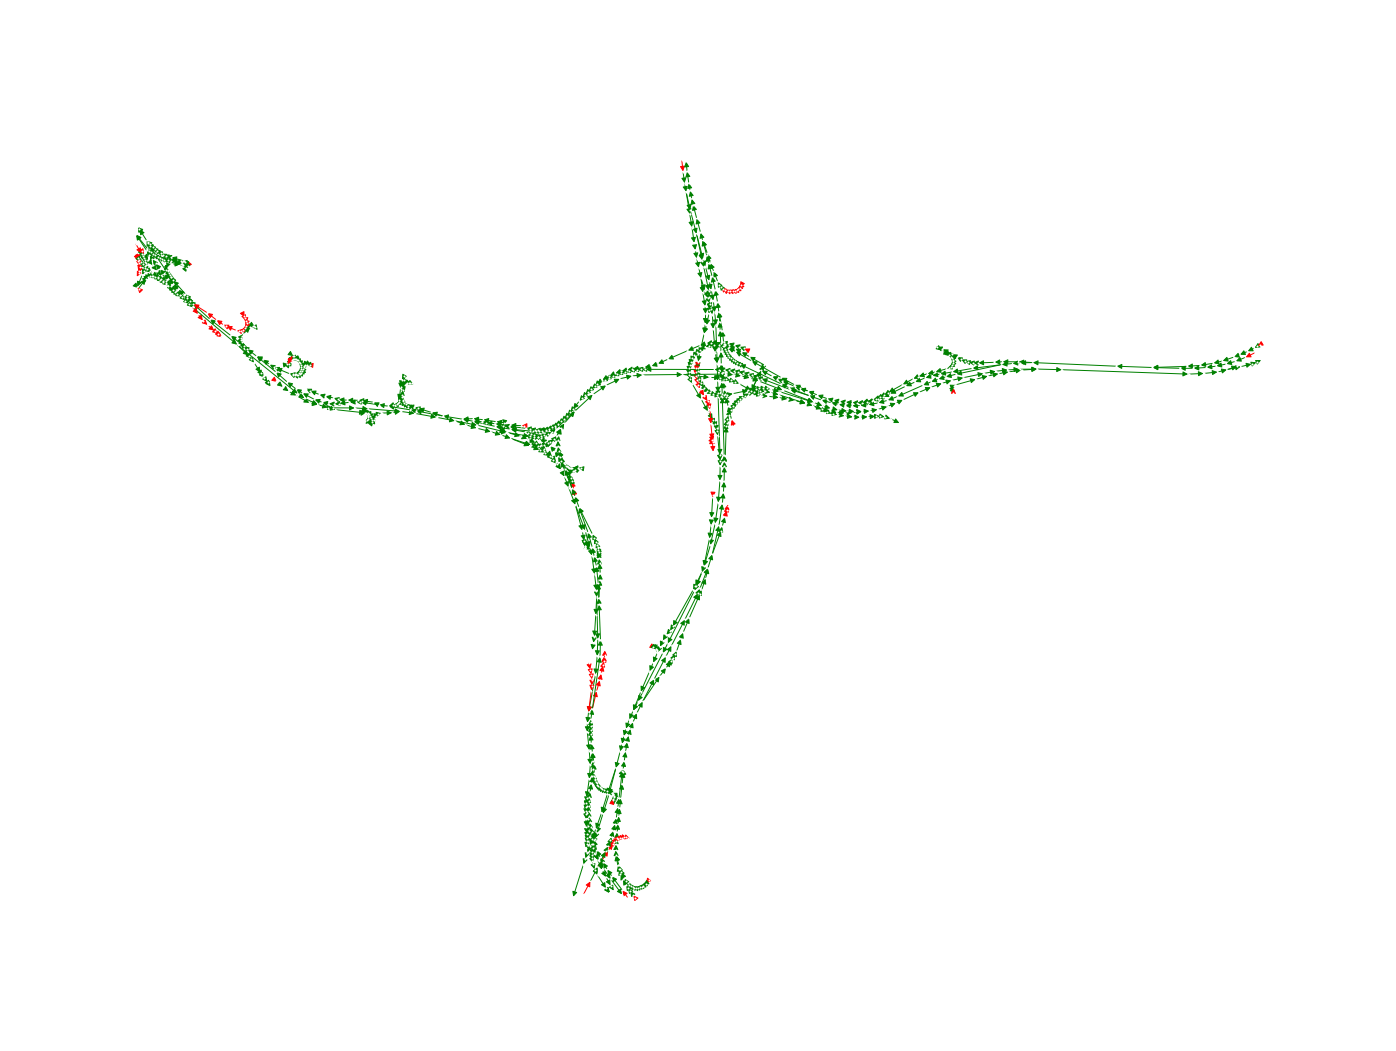

In [15]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
edge_colors = ["red" if G[u][v]["flow"] == 0 else "green" for u,v in G.edges]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)
plt.show()

Speeds at each edge:

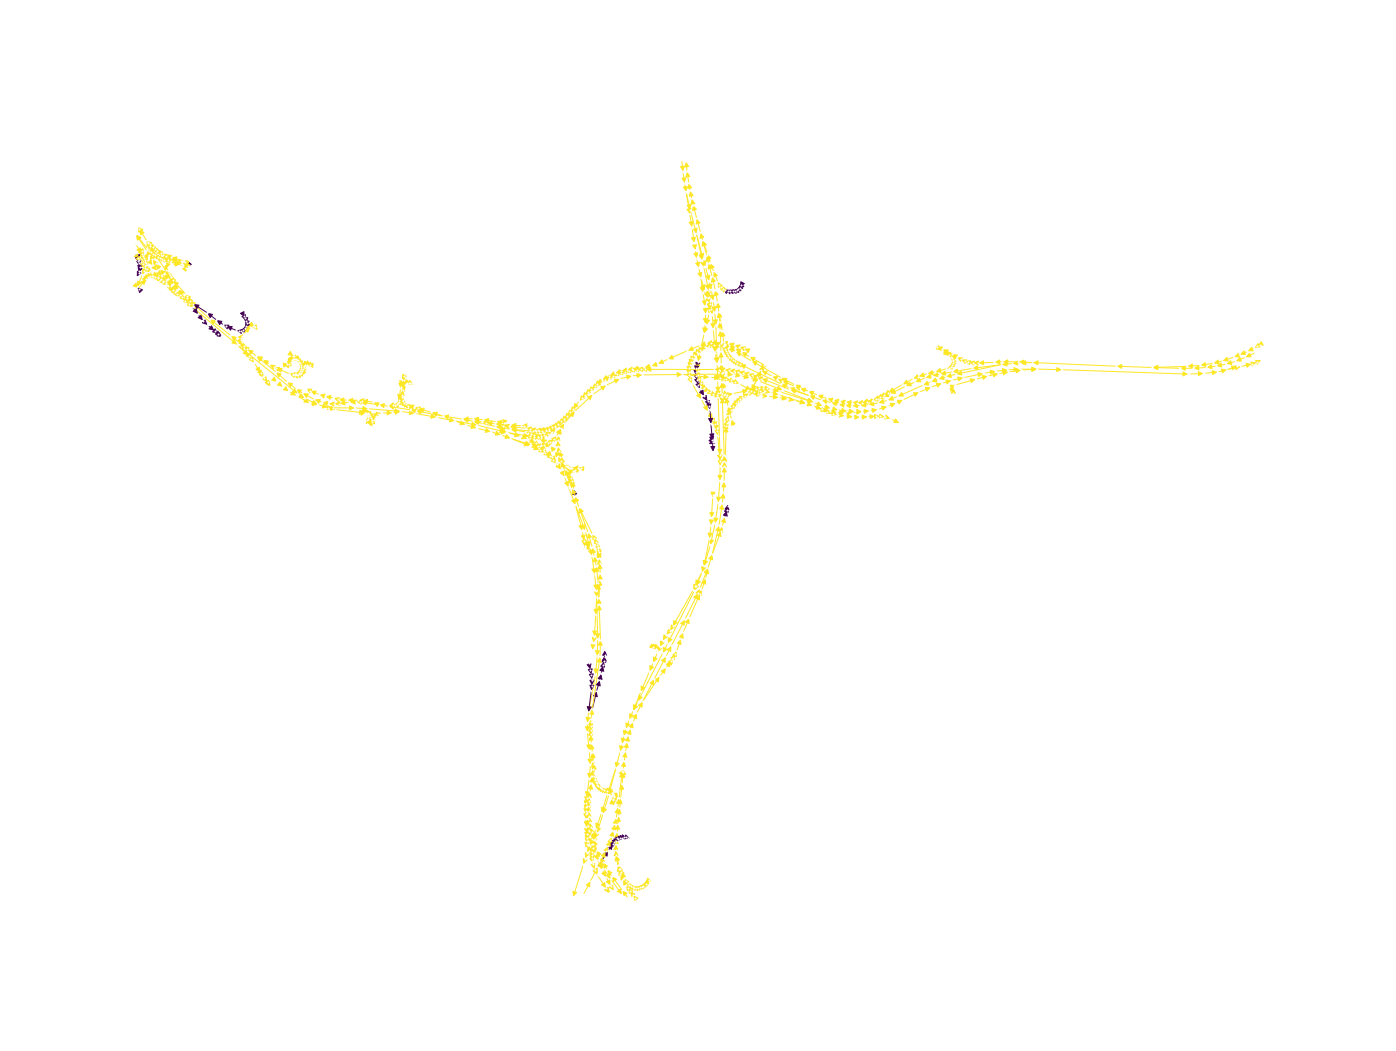

In [16]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
edge_colors = [cmap(G[u][v]["vehicle_speed"]) for u, v in G.edges]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)
plt.show()

## Validation

In [17]:
import pickle 
import numpy as np

with open('data/small_speeds.pkl', 'rb') as f:
    speeds = pickle.load(f)

with open('data/small_flows.pkl', 'rb') as f:
    flows = pickle.load(f)

GEH statistic for sensor locations (a good error is GEH<5 for at least 90% of sensors):

In [18]:
detectors = []

sat = 0

for k, c in flows.items():
    u, v = [int(i) for i in k]
    m = G[u][v]["flow"] / 3
    geh = np.sqrt(2 * (m - c) ** 2 / (m + c))
    sat += (geh < 5)
    detectors.append(G[u][v]["edge_id"])
    print(G[u][v]["edge_id"], m, c, geh)
    
print("GEH<5 for", 100 * sat / len(detectors), "%")

28 474.0 513.3680555555555 1.7718192939831259
82 3962.0 3997.3967803030305 0.5610979482393628
106 316.0 374.99138332557055 3.173710160927541
132 3538.0 3526.808197282795 0.18830630259198666
167 4867.0 4940.214408037447 1.045535342836743
168 5470.0 5469.434981162233 0.007639773439779584
214 3950.0 3929.2595238095237 0.3304387864351789
224 2408.0 2363.6783879438294 0.9073920369389253
232 176.0 190.07737801872844 1.0405197419604608
236 4993.0 5618.16120561708 8.582732197195929
247 189.0 190.82601530311948 0.1325034105870685
283 2665.0 2912.1792442059595 4.68079581252675
317 5130.0 5128.9810480648475 0.01422710649957337
353 311.0 312.1148539465506 0.06316098893802864
369 4332.0 4384.524717433497 0.7956224691741483
414 3181.0 3167.9422308482704 0.2317572327159277
446 829.0 830.7866586538462 0.062019812706253376
463 1993.0 1981.5700422422651 0.25639794839720226
473 4758.0 4744.8544354378355 0.19070724922771404
503 4020.0 4070.063363397648 0.7871528272194196
525 2665.0 2652.696426532709 0.238

Error in simulated speeds:

In [19]:
err = 0
high_err_detectors = []

for k, s in speeds.items():
    u, v = [int(i) for i in k]
    m = G[u][v]["vehicle_speed"]
    err += (s * 0.44704 - G[u][v]["vehicle_speed"]) ** 2
    if abs(s * 0.44704 - G[u][v]["vehicle_speed"]) > 2:
        high_err_detectors.append(G[u][v]["edge_id"])
    print(G[u][v]["edge_id"], s * 0.44704, G[u][v]["vehicle_speed"])
    

print("Speed MSE:", err / len(speeds))

82 25.418745200000004 26.89
132 27.883021411576664 24.6
167 28.61101168443886 25.21
168 28.18133474049549 24.89
214 24.317113333333335 26.06
224 29.159905249457694 24.49
236 27.72192828405069 22.96
283 27.793000958100237 25.8
317 28.412987612284507 23.68
369 25.690014352323324 26.13
414 28.67568421965978 27.46
463 26.969547051489897 26.53
473 21.418192184495943 24.99
503 25.347877425276856 24.37
525 29.513283249686033 25.72
542 28.73960139559311 24.22
629 26.239859772120106 24.08
638 21.9767658 26.04
698 27.44294296609202 25.83
766 30.00822476721087 26.6
809 25.765555384861283 24.28
911 23.035012827956987 25.38
926 20.48484370909921 11.01
955 25.299064883205848 25.88
1046 29.30750398538646 26.58
1084 29.597896249343535 25.1
1088 29.019433940860832 27.54
1133 27.941827152871326 24.17
1175 29.139148180385885 27.75
1199 27.74307579221372 25.48
Speed MSE: 11.465913363944985


Detectors with high speed errors:

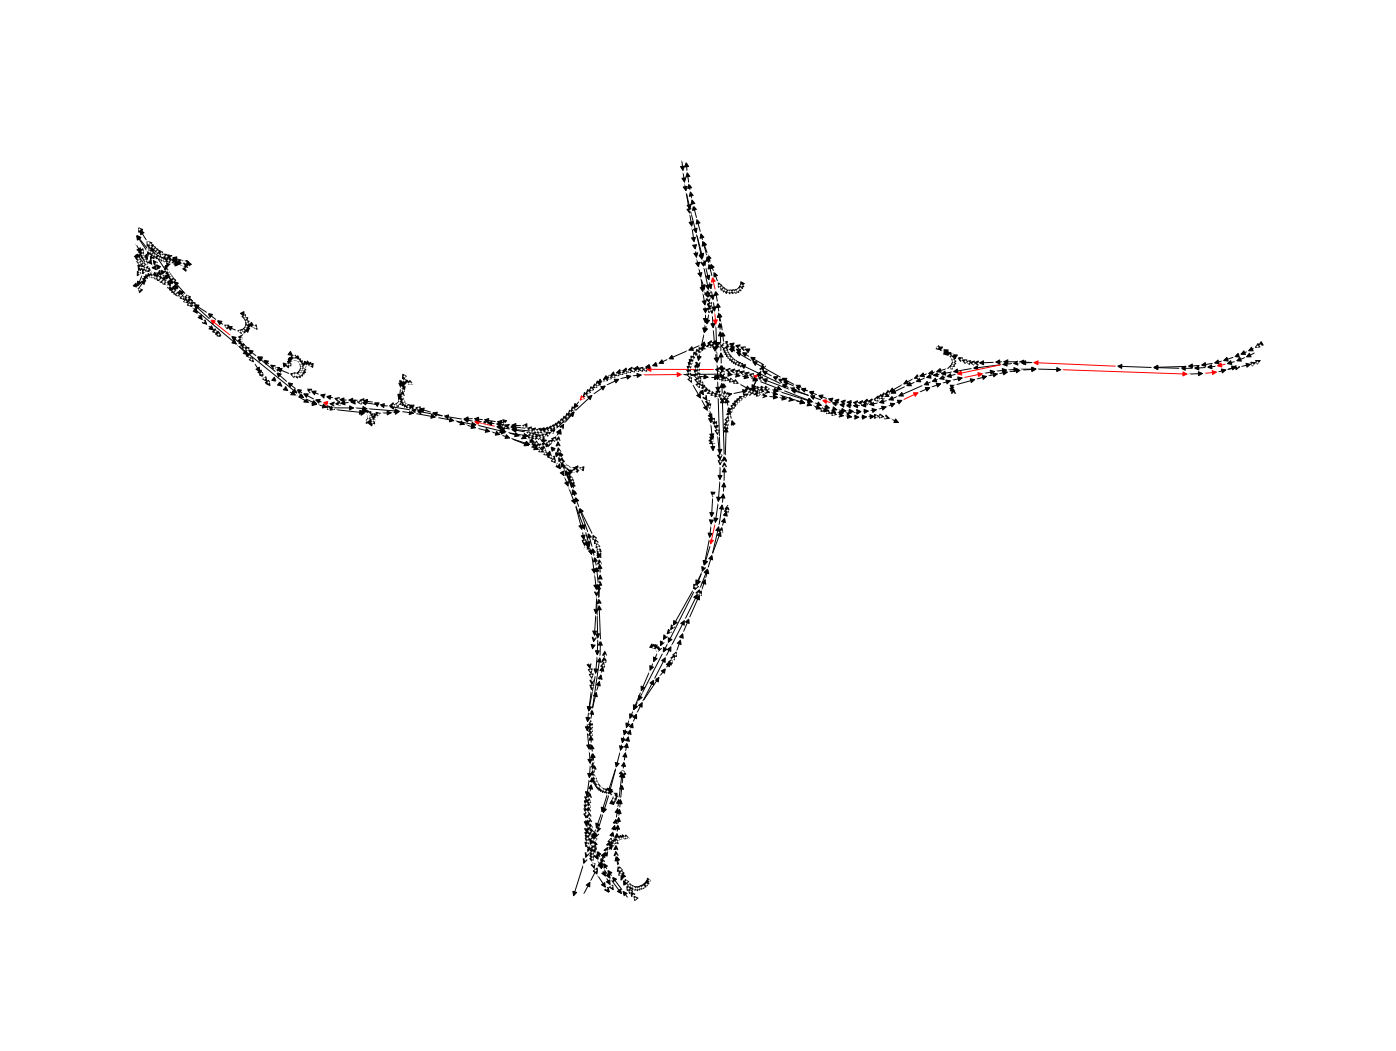

In [20]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

edge_colors = ["red" if G[u][v]["edge_id"] in high_err_detectors else "black" for u, v in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)

All detector locations:

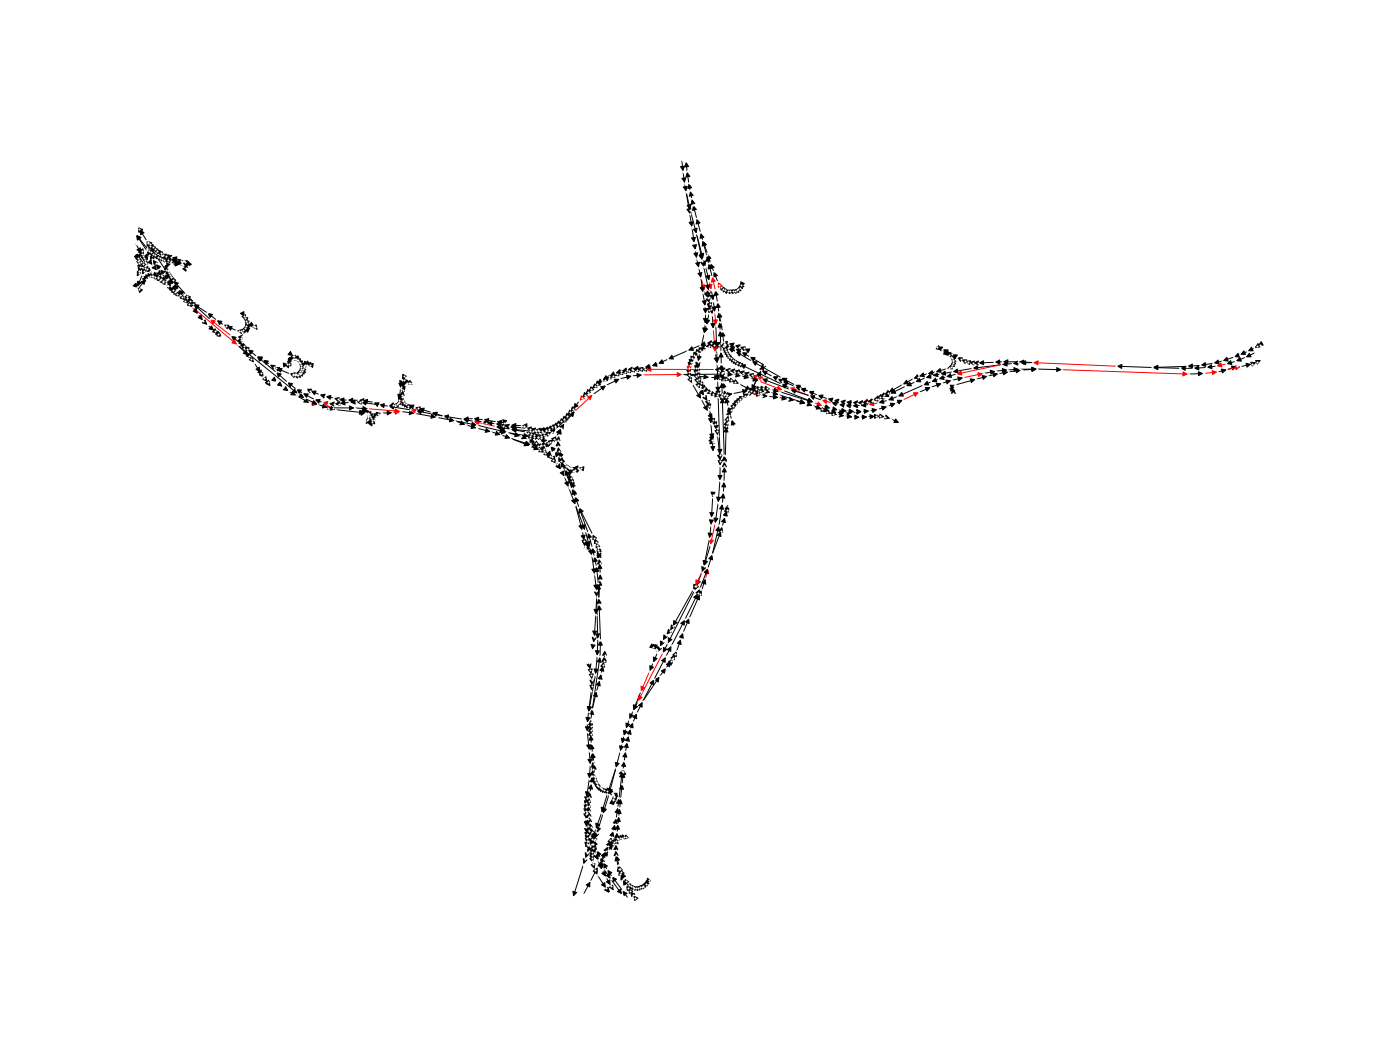

In [21]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

edge_colors = ["red" if G[u][v]["edge_id"] in detectors else "black" for u, v in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)

(array([563., 226., 119.,  82.,  71.,  22.,  40.,  41.,  38.,  18.]),
 array([    0. ,  1699.2,  3398.4,  5097.6,  6796.8,  8496. , 10195.2,
        11894.4, 13593.6, 15292.8, 16992. ]),
 <BarContainer object of 10 artists>)

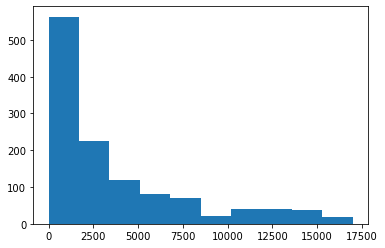

In [21]:
plt.hist([G[u][v]["flow"] for u,v in G.edges])

(array([12.,  1.,  1.,  3.,  3.,  2.,  6.,  5.,  7.,  3.]),
 array([ 153.79798995,  700.23431152, 1246.67063308, 1793.10695465,
        2339.54327622, 2885.97959778, 3432.41591935, 3978.85224092,
        4525.28856248, 5071.72488405, 5618.16120562]),
 <BarContainer object of 10 artists>)

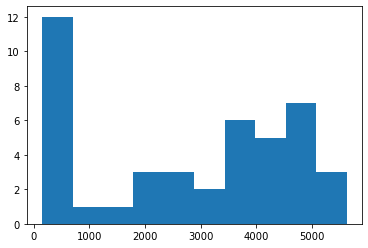

In [22]:
plt.hist(flows.values())

(array([ 84.,   1.,   0.,   1.,   0.,   3.,  18.,  26., 258., 829.]),
 array([ 0.   ,  2.936,  5.872,  8.808, 11.744, 14.68 , 17.616, 20.552,
        23.488, 26.424, 29.36 ]),
 <BarContainer object of 10 artists>)

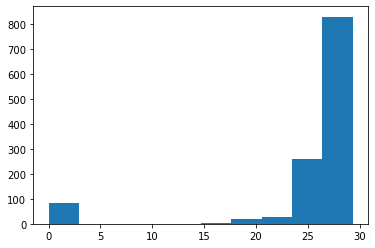

In [23]:
plt.hist(data["vehicle_speed"])

(array([2., 1., 1., 0., 1., 5., 2., 6., 6., 6.]),
 array([20.48484371, 21.43718181, 22.38951992, 23.34185803, 24.29419613,
        25.24653424, 26.19887234, 27.15121045, 28.10354856, 29.05588666,
        30.00822477]),
 <BarContainer object of 10 artists>)

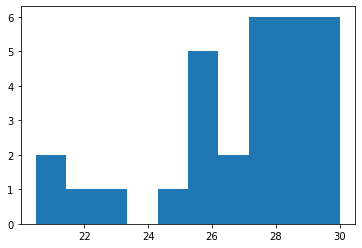

In [24]:
plt.hist([v * 0.44704 for v in speeds.values()])

## Smoothness and Estimation

In [24]:
G_undirected = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"])
H = nx.line_graph(G_undirected)
H.add_nodes_from((node, G_undirected.edges[node]) for node in H)

def smoothness(H, attr):
    L = nx.laplacian_matrix(H)
    x = np.array([attrs[attr] for _, attrs in H.nodes(data=True)])
    return x.transpose() @ L @ x

smoothness(H, "vehicle_speed") / H.number_of_nodes()

14.352409075907595

In [25]:
smoothness(H, "flow") / H.number_of_nodes()

8887190.131188119

In [60]:
def fix_sensors(H, x_hat, sensors, attr):
    for i, (v, attrs) in enumerate(H.nodes(data=True)):
        if v in sensors:
            x_hat[i] = attrs[attr]

def predict(H, P, max_iter, sensors, attr):    
    x_hat = np.zeros(H.number_of_nodes())
    fix_sensors(H, x_hat, sensors, attr)        
    
    for t in range(max_iter):
        x_hat = P @ x_hat
        fix_sensors(H, x_hat, sensors, attr)
    
    return x_hat

In [66]:
from tqdm.notebook import tqdm

def choose_sensors(H, attr, k=None):
    if k == None:
        k = int(H.number_of_nodes() / 50)
        
    D = np.zeros((H.number_of_nodes(), H.number_of_nodes()))
    for i, v in enumerate(H.nodes()):
        D[i][i] = H.degree[v]
        
    P = np.linalg.inv(D) @ nx.adjacency_matrix(H)
    L = nx.laplacian_matrix(H)
            
    sensors = set()
    for i in tqdm(range(k)):
        candidate, best = None, float("inf")
        for v in H.nodes():
            pred = predict(H, P, 1000, sensors.union([v]), attr)
            err = pred.transpose() @ L  @ pred
            if best > err:
                candidate = v
                best = err
                
        sensors.add(candidate)
        
    return k

choose_sensors(H, "vehicle_speed")

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/1212 [00:00<?, ?it/s]

KeyboardInterrupt: 